In [30]:
import json
import csv
import os
import re

import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.optimize import minimize_scalar, LinearConstraint, curve_fit
import skrf as rf
import scqubits as scq

# 1. Q1-Q2 Coupling

## 1.1 Vector Fitting

### 1.1.1 Import Admittance Data

In [5]:
admittance_directory = r'C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Microwave Office\measurement_graphs'

number_of_ports = 3

y_filepath = os.path.join(admittance_directory, 'q1q2_coupling.txt')

frequencies = []
admittances = []

# regex to find matrix element index
matrix_element_regex = re.compile(r"Im\(Y\((?P<i>\d),(?P<j>\d).*")

# determine number of data points
counter = 0
with open(y_filepath, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row in reader:
        counter += 1
        
y_matrix = np.empty((counter-1, number_of_ports, number_of_ports), dtype='complex')

with open(y_filepath, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    
    
    i = 0
    for row in reader:
        if i == 0:
            headers = row[1:]
            matrix_element_order = []
            
            for header in headers:
            
                match = matrix_element_regex.search(header)
                groupdict = match.groupdict()
                matrix_element_order.append((int(groupdict['i'])-1, int(groupdict['j'])-1))
            
        elif i > 0:
            frequency = float(row[0])
            frequencies.append(frequency)
            
            for j, value in enumerate(row[1:]):
                
                index_1, index_2 = matrix_element_order[j]
                
                y_matrix[i-1, index_1, index_2] = 1j*float(value)
                
                if index_1 != index_2:
                    y_matrix[i-1, index_2, index_1] = 1j*float(value)
            
        i += 1
        
frequencies = np.array(frequencies)


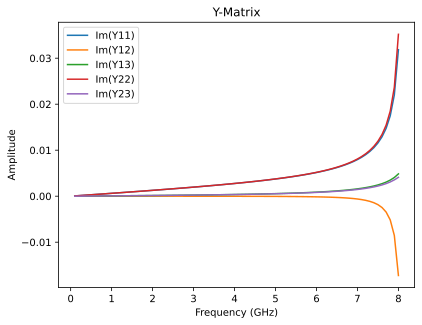

In [8]:
# plot admittances

for i in range(3):
    for j in range(3):
        
        if i == 2 and j == 2:
            continue
        
        if i <= j:
            plt.plot(frequencies, np.imag(y_matrix[:, i, j]), label=f'Im(Y{i+1}{j+1})')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude')

plt.legend()

plt.title('Y-Matrix')

plt.show()

### 1.1.2 Fit Raw Data to Pole Model

In [10]:
frequencies_Hz = frequencies * 1e9
network = rf.Network(frequency=frequencies_Hz, y=y_matrix)
vector_fit = rf.VectorFitting(network)

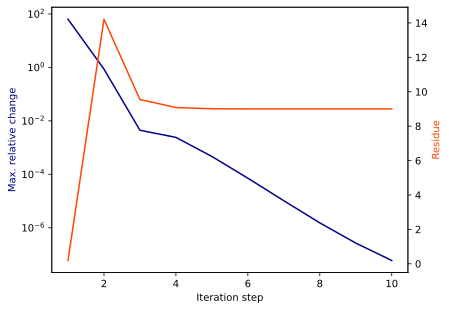

RMS error y11 = 5.996630905299003e-06
RMS error y12 = 1.3199215194498309e-05
RMS error y13 = 8.232255868085039e-06
RMS error y22 = 4.718638316484938e-06
RMS error y23 = 7.293767471118733e-06
RMS error y33 = 0.00023450322704267391


In [22]:
vector_fit.vector_fit(n_poles_real=2, n_poles_cmplx=2, parameter_type='y', fit_constant=False, fit_proportional=True)
vector_fit.plot_convergence()
plt.show()

for i in range(number_of_ports):
    for j in range(number_of_ports):
        if i <= j:
            print(f'RMS error y{i+1}{j+1} = {vector_fit.get_rms_error(i, j, parameter_type="y")}')


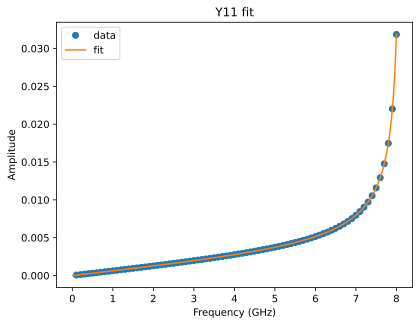

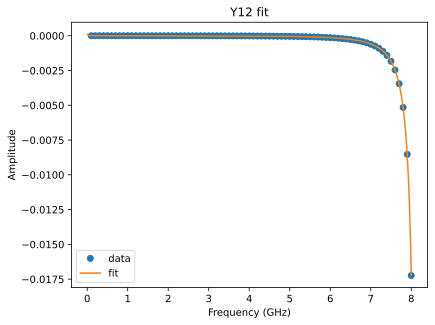

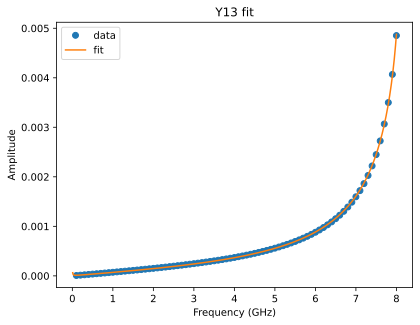

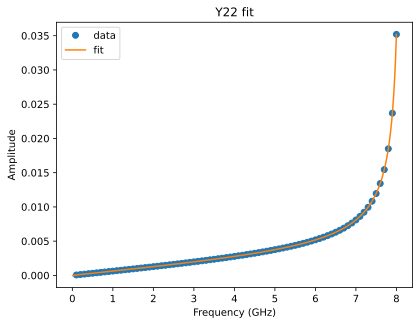

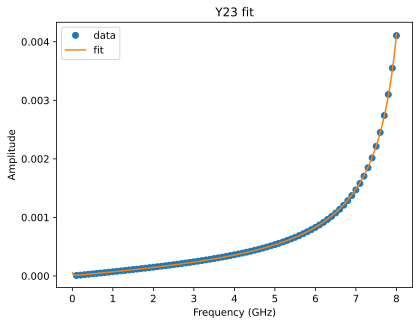

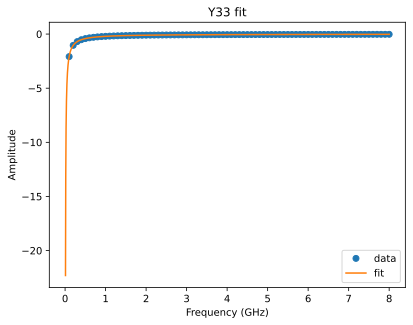

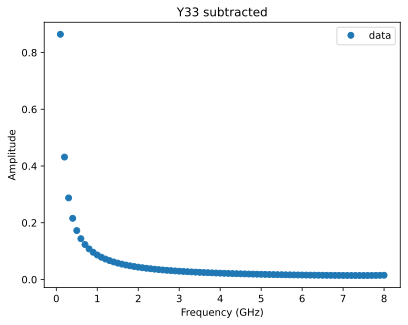

In [23]:
# plot all fits

fit_model_frequencies = np.linspace(0.01e9, 8e9, 10000)

for i in range(number_of_ports):
    for j in range(number_of_ports):
        
        if i <= j:
            model_yij = vector_fit.get_model_response(i, j, fit_model_frequencies)


            # Yij
            plt.plot(frequencies, np.imag(y_matrix[:,i,j]), linestyle='', marker='o', label='data')
            plt.plot(fit_model_frequencies/1e9, np.imag(model_yij), label='fit')

            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Amplitude')

            plt.legend()

            plt.title(f'Y{i+1}{j+1} fit')
            plt.show()
            
# subtracted Y33

L_loop = 0.5404e-9
inductive_model_to_subtract_data = 1/(1j*frequencies*2*np.pi*1e9*L_loop)
# inductive_model_to_subtract_fit = 1/(1j*model_frequencies*2*np.pi*L_loop)



plt.plot(frequencies, np.imag(y_matrix[:,2,2] - inductive_model_to_subtract_data), linestyle='', marker='o', label='data')
# plt.plot(model_frequencies/1e9, np.imag(vector_fit.get_model_response(2, 2, model_frequencies) - inductive_model_to_subtract_fit), label='fit')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude')

plt.legend()

plt.title(f'Y33 subtracted')
plt.show()

### 1.1.3 Optimize Y33 Subtraction

In [24]:
def inductive_model(L, frequencies):
    return 1/(1j * frequencies * 1e9 * 2 * np.pi * L * 1e-9)

In [25]:
def cost_function(x, frequencies, y33_data, max_index):
    return np.linalg.norm((np.imag(inductive_model(x, frequencies)[:max_index] - y33_data[:max_index])))

In [26]:
inductive_model_max_frequency = 1
index = int(inductive_model_max_frequency / (frequencies[-1] - frequencies[0]) * len(frequencies))
print(index)
print(frequencies[index])

10
1.1


In [31]:
bounds = (0, 100)
args = frequencies, y_matrix[:,2,2], index
result = minimize_scalar(cost_function, bounds=bounds, args=args)

In [33]:
loop_self_inductance = result.x
print(f'couper loop self inductance: {loop_self_inductance} nH')

couper loop self inductance: 0.7646529415778074 nH


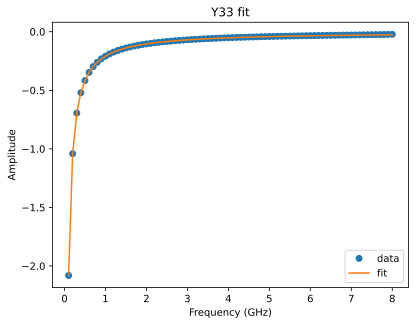

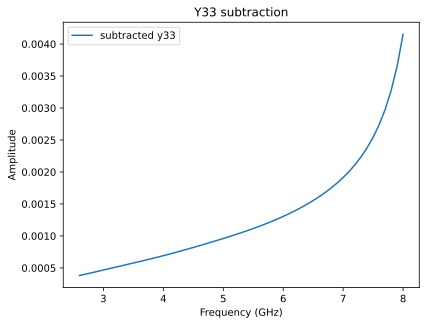

In [34]:
plt.plot(frequencies, np.imag(y_matrix[:,2,2]), linestyle='', marker='o', label='data')
plt.plot(frequencies, np.imag(inductive_model(result.x, frequencies)), label='fit')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude')

plt.legend()

plt.title('Y33 fit')
plt.show()

start_index = 25

# difference
plt.plot(frequencies[start_index:], np.imag(y_matrix[start_index:,2,2] - inductive_model(result.x, frequencies)[start_index:]), label='subtracted y33')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude')

plt.legend()

plt.title('Y33 subtraction')
plt.show()

### 1.1.4 Fit With Y33 Subtraction

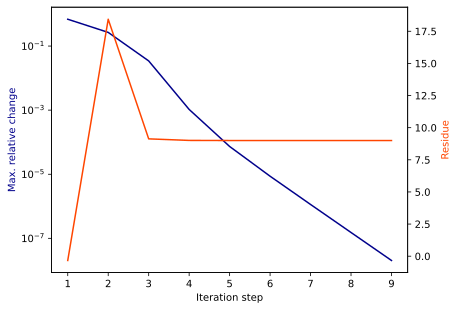

RMS error y11 = 5.550600424427085e-06
RMS error y12 = 2.799396295096866e-06
RMS error y13 = 3.7271429090293535e-06
RMS error y22 = 6.310367207348872e-06
RMS error y23 = 3.0606947384770082e-06
RMS error y33 = 4.5739037876780004e-05


In [38]:
y33_subtracted = y_matrix[:,2,2] - inductive_model(result.x, frequencies)

y_matrix_substracted = np.copy(y_matrix)
y_matrix_substracted[:, 2, 2] = y33_subtracted[:]

y_matrix_substracted_cutoff = y_matrix_substracted[index:, :, :]

cutoff_frequencies = frequencies[index:]
network = rf.Network(frequency=cutoff_frequencies*1e9, y=y_matrix_substracted_cutoff)
vector_fit = rf.VectorFitting(network)


# vector_fit.vector_fit(n_poles_real=1, n_poles_cmplx=1, parameter_type='y', fit_constant=False, fit_proportional=True)
vector_fit.vector_fit(n_poles_real=0, n_poles_cmplx=2, parameter_type='y', fit_constant=False, fit_proportional=True)

vector_fit.plot_convergence()

plt.show()

for i in range(number_of_ports):
    for j in range(number_of_ports):
        if i <= j:
            print(f'RMS error y{i+1}{j+1} = {vector_fit.get_rms_error(i, j, parameter_type="y")}')



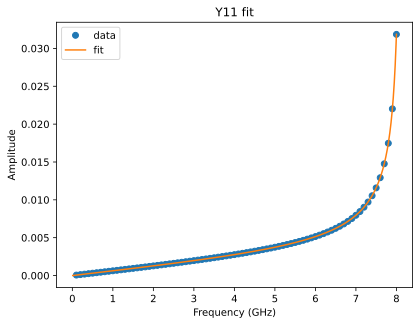

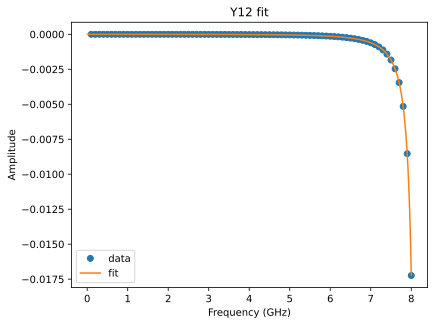

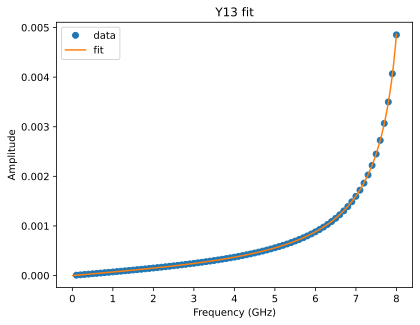

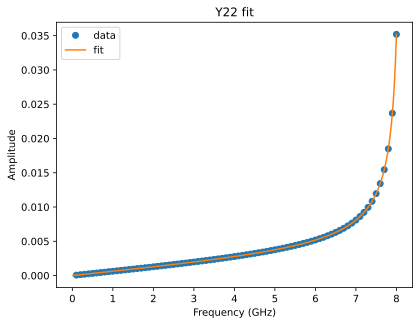

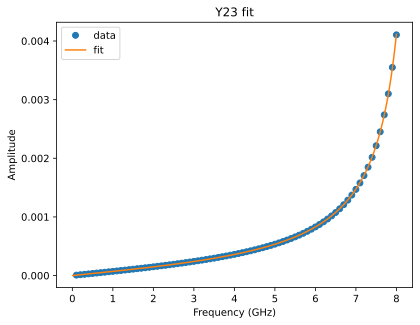

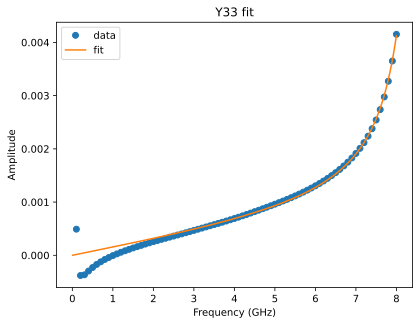

In [40]:
fit_model_frequencies = np.linspace(0.01e9, 8e9, 10000)


for i in range(number_of_ports):
    for j in range(number_of_ports):
        
        if i <= j:
            model_yij = vector_fit.get_model_response(i, j, fit_model_frequencies)


            # Yij
            plt.plot(frequencies, np.imag(y_matrix_substracted[:,i,j]), linestyle='', marker='o', label='data')
            plt.plot(fit_model_frequencies/1e9, np.imag(model_yij), label='fit')

            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Amplitude')

            plt.legend()
            
#             if (i, j) == (0, 1):
#                 plt.xlim(0, 0.5)
#                 plt.ylim(-0.00001, 0.00001)

            plt.title(f'Y{i+1}{j+1} fit')
            plt.show()

## 1.2 Circuit Parameters

In [70]:
# put residues into NxN matrices where N is number of ports
residues = vector_fit.residues
number_of_poles = len(vector_fit.poles)

print(residues.shape)
print(number_of_poles)

# complex pole
if number_of_poles > 1:
    residues_reshaped = np.real(np.reshape(residues, (number_of_ports, number_of_ports, number_of_poles)))
else:
    residues_reshaped = np.real(np.reshape(residues, (number_of_ports, number_of_ports)))
    
print()
print('Residue from complex poles')
print(residues_reshaped)

(9, 2)
2

Residue from complex poles
[[[ 29283730.76955552  19860899.53133234]
  [ 25139091.82479046 -21637604.60604606]
  [ 18643778.68554825    357437.84626357]]

 [[ 25139091.82479041 -21637604.60604605]
  [ 24622954.69405683  24000025.59458138]
  [ 17126814.6370006     -53147.26986672]]

 [[ 18643778.68554824    357437.84626357]
  [ 17126814.63700062    -53147.26986672]
  [ 14255947.75541369   -125329.11952966]]]


In [71]:
# perform SVD on each NxN residue matrix

# complex pole

# len is number of poles, elements are M NxN rank 1 matrices where M is the rank of the original NxN residue matrix 
r_vectors = []
ranks = []

# if true, only consider the residue of the largest singular value
keep_only_largest_singular_value = True

for k in range(number_of_poles):
    
    if number_of_poles > 1:
        residue = residues_reshaped[:,:,k]
    else:
        residue = residues_reshaped
    
    rank = np.linalg.matrix_rank(residue)

    U, S, V = np.linalg.svd(residue)
    
    print(S)
    
    if keep_only_largest_singular_value:
        rank = 1
        
        r_vectors_k = np.zeros((rank, number_of_ports))
        r_vectors_k[0, :] = np.sqrt(2*np.max(S))*U[:,rank_index]
    else:

        r_vectors_k = np.zeros((rank, number_of_ports))

        for rank_index in range(rank):
            r_vectors_k[rank_index, :] = np.sqrt(2*S[rank_index])*U[:,rank_index]

    ranks.append(rank)
    r_vectors.append(r_vectors_k)
        
        
max_rank = np.max(ranks)
print(ranks)
for r_vector_k in r_vectors:
    print(r_vector_k.shape)

[64864336.97570252  1753176.54295435  1545119.70036915]
[43668602.12358256   313005.14535737   246011.26255586]
[1, 1]
(1, 3)
(1, 3)


In [72]:
print(f'number of ports: {number_of_ports}')
print(f'number of poles: {number_of_poles}')
print(f'max rank: {max_rank}')

number of ports: 3
number of poles: 2
max rank: 1


In [73]:
# define circuit parameters for complex pole

# total capacitances C_k
C_k = 20e-15 # F
C_ks = np.array([C_k]*number_of_poles*max_rank) 
C_ks = np.reshape(C_ks, (number_of_poles, max_rank))


# pole frequency omega_k
omega_ks = np.imag(vector_fit.poles) # Hz * 2pi

frequency_ks = omega_ks/2/np.pi # Hz

# print(f'pole 2 frequency: {frequency_2} GHz')
print(f'\nPole frequencies: {frequency_ks/1e9} GHz')


# pole inductance L_k
print(f'\nMode inductances (nH)')
L_ks = np.zeros((number_of_poles, max_rank))
for k in range(number_of_poles):
    L_ks[k,:] = 1/(omega_ks[k]**2*C_ks[k,:]) # H

    print(f'\tpole {k}: {L_ks[k,:] * 1e9}')


# Coupling capacitances [C_ki]_j = sqrt(C_k)/(omega_k) [r_ki]_j

C_coupling_ks = np.zeros((number_of_poles, max_rank, number_of_ports))

print('\nCoupling capacitances (fF)')
for k in range(number_of_poles):
    for rank_index in range(max_rank):
        C_coupling_ks[k, rank_index, :] = np.sqrt(C_ks[k, rank_index])/omega_ks[k] * r_vectors[k][rank_index, :]


        print(f'\tpole {k}, rank index {rank_index}: {C_coupling_ks[k, rank_index, :] * 1e15}')


# capacitance to ground C_kig = C_k - sum_j [C_ki]_j
C_g_ks = np.zeros((number_of_poles, max_rank))

print('\nPole capacitance to ground (fF)')
for k in range(number_of_poles):
    for rank_index in range(max_rank):
        C_g_ks[k, rank_index] = C_ks[k, rank_index] - np.sum(C_coupling_ks[k, rank_index, :])
        
        print(f'\tpole {k}, rank index {rank_index}: {C_g_ks[k, rank_index] * 1e15} fF')


# fit proportional capacitance C_n
C_n = np.reshape(vector_fit.proportional_coeff, (number_of_ports, number_of_ports)) # F
print(f'\nproportional coefficients (fF): \n{C_n * 1e-15}')


Pole frequencies: [8.62503372 8.14611457] GHz

Mode inductances (nH)
	pole 0: [17.02506051]
	pole 1: [19.0857504]

Coupling capacitances (fF)
	pole 0, rank index 0: [ 22.30151533 -15.08522905 -12.59101616]
	pole 1, rank index 0: [-16.90310114 -15.46735297 -11.90817352]

Pole capacitance to ground (fF)
	pole 0, rank index 0: 25.374729884096613 fF
	pole 1, rank index 0: 64.27862762494428 fF

proportional coefficients (fF): 
[[ 6.46189847e-29 -7.29419260e-31 -1.81733359e-30]
 [-7.29419260e-31  6.48448050e-29 -5.08249070e-31]
 [-1.81733359e-30 -5.08249070e-31  1.52375066e-29]]


In [74]:
# define capacitance matrix

first_term = 0
second_term = 0
for k in range(number_of_poles):
    
    omega = omega_ks[k]
        
    if omega == 0:
        continue
    
    for rank_index in range(max_rank):
        
        r_vector = r_vectors[k][rank_index, :]
        
        first_term += np.outer(r_vector, r_vector)/(omega**2)
        
        second_term += - np.sqrt(C_ks[k, rank_index])/omega * np.diag(r_vector)


cap_matrix = C_n + first_term + second_term

cap_matrix_fF = cap_matrix * 1e15

print('Capacitance Matrix (fF)')
print(cap_matrix_fF)

# analyze capacitance matrix to get capacitances to ground

capacitance_to_grounds = np.sum(cap_matrix, -1)
print(f'\nNode capacitance to grounds: {capacitance_to_grounds * 1e15} fF')

Capacitance Matrix (fF)
[[ 98.37419126  -4.47828103  -5.79301752]
 [ -4.47828103 118.73754417  18.19806522]
 [ -5.79301752  18.19806522  54.75361045]]

Node capacitance to grounds: [ 88.10289272 132.45732836  67.15865815] fF


## 1.3 ScQubits

In [75]:
circuit_parameters = {}

for k in range(number_of_poles):
    for rank_index in range(max_rank):
        circuit_parameters[f'pole_inductance_{k*max_rank + rank_index}'] = L_ks[k, rank_index] * 1e9 # nH
        circuit_parameters[f'pole_capacitance_ground_{k*max_rank + rank_index}'] = C_g_ks[k, rank_index] * 1e15 # fF
        
        for i in range(number_of_ports):
            circuit_parameters[f'coupling_capacitance_{k*max_rank + rank_index}_{i}'] = C_coupling_ks[k, rank_index, i] * 1e15 # fF

for i in range(number_of_ports):
    
    circuit_parameters[f'node_capacitance_ground_{i}'] = capacitance_to_grounds[i] * 1e15 # fF
    
    for j in range(number_of_ports):
        
        if i != j:
            circuit_parameters[f'internode_capacitance_{i}{j}'] = -cap_matrix_fF[i, j] # fF
            
circuit_parameters['coupler_inductance'] = loop_self_inductance
            
            
for key, value in circuit_parameters.items():
    print(f'{key}: {value}')

pole_inductance_0: 17.025060506087936
pole_capacitance_ground_0: 25.374729884096613
coupling_capacitance_0_0: 22.301515326983445
coupling_capacitance_0_1: -15.085229053943037
coupling_capacitance_0_2: -12.591016157137018
pole_inductance_1: 19.08575040397451
pole_capacitance_ground_1: 64.27862762494428
coupling_capacitance_1_0: -16.90310114106701
coupling_capacitance_1_1: -15.46735296671527
coupling_capacitance_1_2: -11.908173517162
node_capacitance_ground_0: 88.1028927161993
internode_capacitance_01: 4.47828102836111
internode_capacitance_02: 5.793017515986143
node_capacitance_ground_1: 132.45732835724294
internode_capacitance_10: 4.478281028361086
internode_capacitance_12: -18.198065216284576
node_capacitance_ground_2: 67.15865815009097
internode_capacitance_20: 5.793017515986124
internode_capacitance_21: -18.19806521628456
coupler_inductance: 0.7646529415778074


In [76]:
# C_q1 tot
C_tot_q1 = circuit_parameters['node_capacitance_ground_0'] + np.sum([circuit_parameters[f'internode_capacitance_0{i}'] for i in range(1,3)]) + np.sum([circuit_parameters[f'coupling_capacitance_0_{i}'] for i in range(3)])
C_tot_q1 = circuit_parameters['node_capacitance_ground_0'] + np.sum([circuit_parameters[f'internode_capacitance_0{i}'] for i in range(1,3)])
print(f'C_tot_q1: {C_tot_q1}')

C_tot_q1: 98.37419126054655


### 1.3.1 Create circuit yaml

In [102]:
def create_circuit_yaml(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances, loop_phase=0):
    
    yaml_str = 'branches:'
    
    total_num_poles = num_poles * num_ranks
    num_nodes = 1 + num_ports + total_num_poles
    
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            # add capacitances
            capacitance = None
    
            if i == 0:
                # ground to everything (capacitances)
                if j in range(1, 1 + num_ports):
                    capacitance = circuit_parameters[f'node_capacitance_ground_{j - 1}']
                elif j in range(1 + num_ports, 1 + num_ports + total_num_poles):
                    capacitance = circuit_parameters[f'pole_capacitance_ground_{j - 1 - num_ports}']
                    
                    inductance = circuit_parameters[f'pole_inductance_{j - 1 - num_ports}']
                    yaml_str += f'\n- ["L", {i}, {j}, {inductance}nH]'
                    
            elif i in range(1, 1 + num_ports):
                # q1, q2, c to everything (capacitance)
                if j in range(1, 1 + num_ports):
                    capacitance = circuit_parameters[f'internode_capacitance_{i - 1}{j - 1}']
                elif j in range(1 + num_ports, 1 + num_ports + total_num_poles):
                    capacitance = circuit_parameters[f'coupling_capacitance_{j - 1 - num_ports}_{i - 1}']
            
            if not capacitance is None:
                yaml_str += f'\n- ["C", {i}, {j}, {capacitance}fF]'
                
    # junctions: [EJ_q1, EJ_q2, EJ_c]
    EJ_q1, EJ_q2, EJ_c = junction_EJs
    
    # parasitic capacitances: [C_parasitic_q1, C_parasitic_q2, C_parasitic_c]
    C_parasitic_q1, C_parasitic_q2, C_parasitic_c = parasitic_capacitances
    
    # coupler inductance
    L_loop = circuit_parameters['coupler_inductance']
                
    # add junctions and coupler inductor
    
    yaml_str += f'\n- ["JJ", 0, 1, EJ_q1 = {EJ_q1}, {C_parasitic_q1}fF]'
    yaml_str += f'\n- ["JJ", 0, 2, EJ_q2 = {EJ_q2}, {C_parasitic_q2}fF]'
    yaml_str += f'\n- ["JJ", 0, 3, EJ_c = {EJ_c}, C_parasitic_c = {C_parasitic_c}fF]'
    yaml_str += f'\n- ["L", 0, 3, {L_loop}nH]'
    
    return yaml_str
                    

In [177]:
# define junction parameters

h = 6.626e-34
hbar = h/(2*np.pi)
e = 1.6e-19 # Coulombs

Phi0 = h/(2*e)

# qubit 1 
EJ_q1 = 20 # GHz
EJ_q1_J = EJ_q1 * h # J

L_J1 = (Phi0/(2*np.pi))**2/EJ_q1_J # nH
# L_J = L_J_H * 1e9 # nH

# qubit 2
EJ_q2 = 20 # GHz
# EJ_q2 = 21 # GHz
EJ_q2_J = EJ_q2 * h # J

L_J2 = (Phi0/(2*np.pi))**2/EJ_q2_J # nH
# L_J = L_J_H * 1e9 # nH

C_parasitic_q = 12 # fF

# coupler
EJ_c = 271.35431519 # GHz
EJ_c_J = EJ_c * h # J

L_c0 = (Phi0/(2*np.pi))**2/EJ_c_J # nH
# L_c0 = L_c0_H * 1e9 # nH

C_parasitic_c = 51.81966507 # fF

print(f'Qubit 1 junction inductance: {L_J1} nH')
print(f'Qubit 2 junction inductance: {L_J2} nH')

print(f'Coupler junction inductance: {L_c0} nH')

frequency_estimate1 = 1/np.sqrt(L_J1 * 129.5)/(2*np.pi)*1e6
frequency_estimate2 = 1/np.sqrt(L_J2 * 132.8)/(2*np.pi)*1e6

print(f'frequency estimate Q1: {frequency_estimate1} MHz')
print(f'frequency estimate Q2: {frequency_estimate2} MHz')



Qubit 1 junction inductance: 8.195241245289674 nH
Qubit 2 junction inductance: 8.195241245289674 nH
Coupler junction inductance: 0.6040251277781549 nH
frequency estimate Q1: 4885.447787307838 MHz
frequency estimate Q2: 4824.365719815712 MHz


In [178]:
# check what EJ corresponds to a coupler inductance

L_c0_impedance_response = 0.638 # nH
EJ_c_impedance_response = (Phi0/(2*np.pi))**2/L_c0_impedance_response/h

print(f'EJ from impedance response formula: {EJ_c_impedance_response}')

EJ from impedance response formula: 256.9041142724036


In [179]:
junction_EJs = (EJ_q1, EJ_q2, EJ_c)
parasitic_capacitances = (C_parasitic_q, C_parasitic_q, C_parasitic_c)

circuit_yaml = create_circuit_yaml(circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances)

In [180]:
print(circuit_yaml)

branches:
- ["C", 0, 1, 88.1028927161993fF]
- ["C", 0, 2, 132.45732835724294fF]
- ["C", 0, 3, 67.15865815009097fF]
- ["L", 0, 4, 17.025060506087936nH]
- ["C", 0, 4, 25.374729884096613fF]
- ["L", 0, 5, 19.08575040397451nH]
- ["C", 0, 5, 64.27862762494428fF]
- ["C", 1, 2, 4.47828102836111fF]
- ["C", 1, 3, 5.793017515986143fF]
- ["C", 1, 4, 22.301515326983445fF]
- ["C", 1, 5, -16.90310114106701fF]
- ["C", 2, 3, -18.198065216284576fF]
- ["C", 2, 4, -15.085229053943037fF]
- ["C", 2, 5, -15.46735296671527fF]
- ["C", 3, 4, -12.591016157137018fF]
- ["C", 3, 5, -11.908173517162fF]
- ["JJ", 0, 1, EJ_q1 = 20, 12fF]
- ["JJ", 0, 2, EJ_q2 = 20, 12fF]
- ["JJ", 0, 3, EJ_c = 271.35431519, C_parasitic_c = 51.81966507fF]
- ["L", 0, 3, 0.7646529415778074nH]


### 1.3.2 Analyze Circuit

In [181]:
def create_circuit(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances, phase=0):   
    circuit_yaml = create_circuit_yaml(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances)
    circuit = scq.Circuit(circuit_yaml, from_file=False, ext_basis='harmonic', basis_completion='canonical')

    circuit.configure(np.identity(5))
#     circuit.variable_transformation()

    circuit.cutoff_n_1 = 6
    circuit.cutoff_n_2 = 6
    circuit.cutoff_ext_3 = 10
    circuit.cutoff_ext_4 = 6
    circuit.cutoff_ext_5 = 6
    
    circuit.Φ1 = phase

    return circuit

In [182]:
junction_EJs = (EJ_q1, EJ_q2, EJ_c)
parasitic_capacitances = (C_parasitic_q, C_parasitic_q, C_parasitic_c)

circuit = create_circuit(circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances)

In [183]:
print(f'var categories: {circuit.var_categories}')

var categories: {'periodic': [1, 2], 'extended': [3, 4, 5], 'free': [], 'frozen': [], 'sigma': []}


In [184]:
print(f'variable transformation')
print(circuit.transformation_matrix)
circuit.variable_transformation()

variable transformation
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


<IPython.core.display.Latex object>

In [185]:
print(f'Hamiltonian:')
circuit.sym_hamiltonian()

Hamiltonian:


<IPython.core.display.Latex object>

In [186]:
circuit.sym_external_fluxes()

{Φ1: (Branch(L, 0, 3, id_str: 19),
  [Branch(JJ, 0, 3, id_str: 18), Branch(L, 0, 3, id_str: 19)])}

In [187]:
circuit.variable_transformation()

<IPython.core.display.Latex object>

In [188]:
# set cutoff
circuit.cutoff_names

circuit.cutoff_n_1 = 6
circuit.cutoff_n_2 = 6
circuit.cutoff_ext_3 = 10
circuit.cutoff_ext_4 = 6
circuit.cutoff_ext_5 = 6


In [189]:
evals = circuit.eigenvals(3)
q1_frequency = evals[1] - evals[0]
q2_frequency = evals[2] - evals[0]
print(q1_frequency)
print(q2_frequency)

4.629860162202817
5.038102445030688


Spectral data:   0%|          | 0/11 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='EJ_q2', ylabel='energy [GHz]'>)

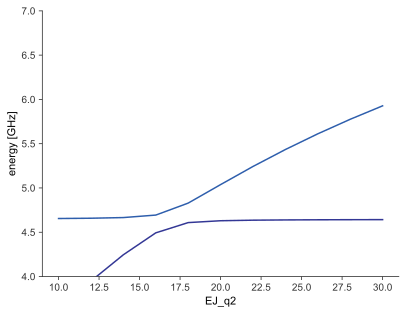

In [193]:
# plot eigenvals vs sweeping EJ_q2

EJs = np.linspace(10, 30, 11)

circuit.plot_evals_vs_paramvals('EJ_q2', EJs, evals_count=3, subtract_ground=True, ylim=(4, 7))

In [194]:
spectrum_data = circuit.get_spectrum_vs_paramvals('EJ_q2', EJs, evals_count=3, subtract_ground=True)

Spectral data:   0%|          | 0/11 [00:00<?, ?it/s]

(11, 3)


Text(0, 0.5, 'Frequency (GHz)')

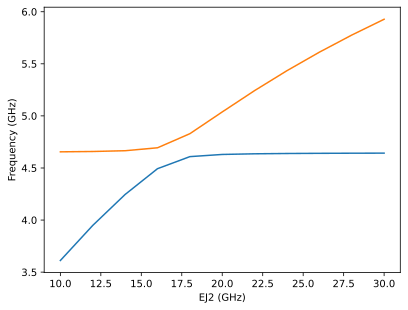

In [197]:
print(spectrum_data.energy_table.shape)
plt.plot(EJs, spectrum_data.energy_table[:,1])
plt.plot(EJs, spectrum_data.energy_table[:,2])

plt.xlabel('EJ2 (GHz)')
plt.ylabel('Frequency (GHz)')

## 1.4 Parameter Sweeps

### 1.4.1 Sweep Avoided Crossing
Sweep EJ_q2 and plot eigenvalues

In [198]:
def sweep_avoided_crossing(EJs, circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances, phase=0):

    EJ_q1, EJ_q2, EJ_c = junction_EJs
    
    frequencies = []    
    
    for EJ in EJ_s:
    
        junction_EJs = EJ_q1, EJ, EJ_c

        circuit = create_circuit(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances, phase=phase)

        circuit.info()

        # get the first three eigenfrequencies
        evals = circuit.eigenvals(3)
        q1_frequency = evals[1] - evals[0]
        q2_frequency = evals[2] - evals[0]

        frequencies.append([q1_frequency, q2_frequency])

    return np.array(frequencies)

In [200]:
EJ_start = 10
EJ_stop = 30
num_points = 4

EJ_s = np.linspace(EJ_start, EJ_stop, num_points)

phase = 0
# phase = np.pi
# phase = np.pi/2

junction_EJs = (EJ_q1, EJ_q2, EJ_c)
parasitic_capacitances = (C_parasitic_q, C_parasitic_q, C_parasitic_c)

qubit_frequencies = sweep_avoided_crossing(EJ_s, circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances, phase=phase)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [201]:
avoided_crossing_freqs_phase_0 = np.copy(qubit_frequencies)
avoided_crossing_EJs_phase_0 = np.copy(EJ_s)

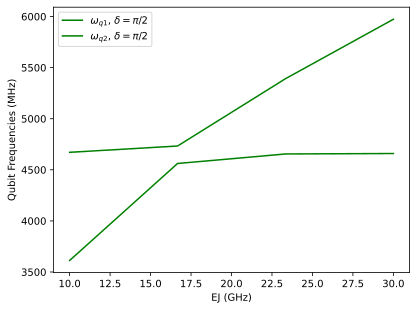

In [202]:

plt.plot(avoided_crossing_EJs_phase_0, avoided_crossing_freqs_phase_0[:,0]*1000, color='green', label='$\omega_{q1}$, $\delta = \pi/2$')
plt.plot(avoided_crossing_EJs_phase_0, avoided_crossing_freqs_phase_0[:,1]*1000, color='green', label='$\omega_{q2}$, $\delta = \pi/2$')

plt.legend()

plt.xlabel('EJ (GHz)')
plt.ylabel('Qubit Frequencies (MHz)')

plt.show()

### 1.4.3 Sweep Fixed Qubit Frequency vs Phase 

In [203]:
def sweep_fixed_qubit_frequency_vs_phase(phases, circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances):
    
    EJ_q1, EJ_q2, EJ_c = junction_EJs
    
    frequency_data = np.zeros((len(phases), 2))
    
    circuit = create_circuit(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances)
    
    for i in range(len(phases)):
        phase = phases[i]
        
        circuit.Φ1 = phase
        
        print(phase)
        
        evals = circuit.eigenvals(3)
        
        print(phase)
        
        frequency_data[i,0] = evals[1] - evals[0]
        frequency_data[i,1] = evals[2] - evals[0]
            
    
#     spectrum_data = circuit.get_spectrum_vs_paramvals('Φ1', phases, evals_count=3, subtract_ground=True)        
                
    return frequency_data

In [204]:
phases = np.linspace(0, 1, 21) # units of 2pi

junction_EJs = (EJ_q1, EJ_q2, EJ_c)
junction_EJs = (EJ_q1, 5, EJ_c)
parasitic_capacitances = (C_parasitic_q, C_parasitic_q, C_parasitic_c)

frequency_data = sweep_fixed_qubit_frequency_vs_phase(phases, circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances)

0.0
0.0
0.05
0.05
0.1
0.1
0.15000000000000002
0.15000000000000002
0.2
0.2
0.25
0.25
0.30000000000000004
0.30000000000000004
0.35000000000000003
0.35000000000000003
0.4
0.4
0.45
0.45
0.5
0.5
0.55
0.55
0.6000000000000001
0.6000000000000001
0.65
0.65
0.7000000000000001
0.7000000000000001
0.75
0.75
0.8
0.8
0.8500000000000001
0.8500000000000001
0.9
0.9
0.9500000000000001
0.9500000000000001
1.0
1.0


In [205]:
fixed_qubit_sweep_frequency_data_1 = np.copy(frequency_data)

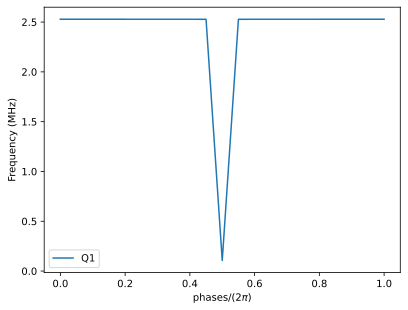

In [207]:
plt.plot(phases, fixed_qubit_sweep_frequency_data_1[:,0], label='Q1')
# plt.plot(phases, frequency_data[:,1], label='Q2')

plt.legend()

plt.xlabel('phases/$(2\pi)$')
plt.ylabel('Frequency (MHz)')

plt.show()